In [1]:
# Python 3.8
# Copyright Alban GOUGOUA

# Exercice d'évaluation pour le poste Inria / AP-HP

## Prérequis
Ce bout de code ci-dessous a été fourni par les évaluateurs. Il permet de lire les données présentes dans le fichier **data.db**.

In [2]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

## Question 1
*Mettre en évidence les problèmes de quqlité de données (données incohérentes, données manquantes etc.)*

### Importer les différentes librairies nécessaires au travail

In [3]:
# Data analysis
import numpy as np
import re
import datetime

# Visualization
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

### Description des données : df_patient

*Quelles sont les variables disponibles ?*

In [4]:
print(df_patient.columns.values)

['patient_id' 'given_name' 'surname' 'street_number' 'address_1' 'suburb'
 'postcode' 'state' 'date_of_birth' 'age' 'phone_number' 'address_2']


*Lesquelles des variables sont catégorielles ou quantitatives ?*
* Nominale : given_name, surname, address_1, suburb, postcode, state, phone_number, adress_2

*Lesquelles des variables sont numériques ?*
* Discrète : street_number, age
* Continue : date_of_birth

In [5]:
# Preview data
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None


In [6]:
df_patient.tail()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
19995,368617,abby,None,19.0,john cleland crescent,boyne island,2290,nsw,19570210.0,NaN,02 92489054,glenmore
19996,796658,dale,priest,19.0,bellchambers crescent,hoppers crossing,3033,wa,19590619.0,31.0,07 20549476,None
19997,511885,alessia,mawlai,4.0,miller street,smithfield,3616,tas,NaN,26.0,03 83466737,None
19998,985932,hannah,mason,1.0,halligan place,beaumaris,2443,wa,19140304.0,25.0,04 41125514,None
19999,925217,jack,mcveigh,5.0,alinda place,thornlands,4350,nsw,19230521.0,26.0,07 52535106,None


*Lesquelles des variables comporteraient des erreurs ou des valeurs manquantes ?*

Il est assez difficile de parcourir l'ensemble des données **df_patient** et relever toutes les erreurs.
Du bref aperçu, je note plus qu'il y a des données manquantes dans la plupart des variables :
* **Moins de 5%** : postcode, suburb, street_number, surname, given_name, address_1, phone_number (*variables donc nécessaires pour la détection des doublons*) ; de plus, il n'y a aucune ligne avec des valeurs manquantes dans toutes ces variables en même temps
* **Entre 5-20%** : state, date_of_birth, age
* **Plus de 50%** : address_2 (*cette variable sera donc supprimée de notre dataframe*)

In [7]:
# df_patient['patient_id'] == len(df_patient)
# df_patient['patient_id'] is the reference

round((df_patient.isna().sum() / df_patient.patient_id.count()).sort_values() * 100, 2)

patient_id        0.00
postcode          1.00
suburb            1.06
street_number     1.91
surname           2.12
given_name        2.20
address_1         3.98
phone_number      4.60
state             9.95
date_of_birth    10.06
age              19.98
address_2        60.54
dtype: float64

In [8]:
# all features which are less 5% of NaN values
# checking of NaN values with multiple conditions
df_patient[(df_patient.given_name.isna()) & (df_patient.surname.isna()) & (df_patient.street_number.isna()) & \
          (df_patient.address_1.isna()) & (df_patient.suburb.isna()) & (df_patient.postcode.isna()) & \
           (df_patient.phone_number.isna())]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2


*Quels sont les types des différentes variables ?*
* 3 variables sont des flottants (float)
* 8 variables des chaînes de caractère (string)

In [9]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     20000 non-null  int64  
 1   given_name     19560 non-null  object 
 2   surname        19575 non-null  object 
 3   street_number  19618 non-null  float64
 4   address_1      19204 non-null  object 
 5   suburb         19788 non-null  object 
 6   postcode       19801 non-null  object 
 7   state          18010 non-null  object 
 8   date_of_birth  17989 non-null  float64
 9   age            16003 non-null  float64
 10  phone_number   19081 non-null  object 
 11  address_2      7893 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1.8+ MB


#### Analyse des variables quantitatives

In [10]:
df_patient.describe(include=['O'])

,given_name,surname,address_1,suburb,postcode,state,phone_number,address_2
count,19560,19575,19204,19788,19801,18010,19081,7893
unique,1171,4273,4326,2925,2021,102,17916,3460
top,emiily,white,paul coe crescent,toowoomba,4350,nsw,02 62271567,brentwood vlge
freq,373,539,57,167,96,6143,4,85


Source pour l'écriture d'une adresse en Australie : https://www.parcelmonkey.com/how-to-guides/how-to-address-mail-to-australia
* street_number address_1
* suburb state postcode

La variable **address_2** avec son grand nombre de valeurs manquantes (**60.54%**) n'est pas nécessaire à notre étude. Elle sera supprimée de notre jeu de données.

*Suppression de la variable **address_2** de notre dataframe.*

In [11]:
df_patient = df_patient.drop(columns='address_2')

**Cohérence des variables quantitatives :**

Pour vérifier la cohérence des valeurs de chaque variable quantitative, j'écrirai 2 fonctions de recherche de valeurs :
* l'une alphabétique appelée *search_alphabetic_values* ;
* l'autre numérique appelée *search_numeric_values*.

Ces fonctions utiliseront les expressions regulières (module *re*).

In [12]:
def search_alphabetic_values(value):
    """
    This function allows the identification of alphabetic values.
        It returns a string or a NoneType according to the length of the result of re.findall.
    
    @parameters
        value: string
    @return
        result: string or NoneType
    """
    result = re.findall(r'\b\D+\B', value)
    if len(result) != 0:
        return result[0]

In [13]:
def search_numeric_values(value):
    """
    This function allows the identification of numeric values.
        It returns a string or a NoneType according to the length of the result of re.findall.
    
    @parameters
        value: string
    @return
        result: string or NoneType
    """
    result = re.findall(r'\b\d+', value)
    if len(result) != 0:
        return result[0]

In [14]:
# Fill NaN by simple values
df_patient.given_name = df_patient.given_name.fillna("")
df_patient.surname = df_patient.surname.fillna("")
df_patient.address_1 = df_patient.address_1.fillna("")
df_patient.suburb = df_patient.suburb.fillna("")
df_patient.postcode = df_patient.postcode.fillna('0')
df_patient.state = df_patient.state.fillna("")
df_patient.phone_number = df_patient.phone_number.fillna('0')

In [15]:
# Select all object type's columns
columns = list(df_patient.select_dtypes(include=['object']).columns.values)

* Les variables **given_name**, **surname** et **state** semblent cohérentes car ne comportent aucune valeur numérique.
* La variable **address_1** comportent 2 valeurs numériques qui sont en réalité des valeurs alphanumériques désignant le domicile exact de la personne.
* Les variables **suburb** et **postcode** comptent chacun 14 valeurs incohérentes :
    * en affichant toutes les valeurs Incohérentes de l'un ou l'autre des variables, je m'aperçois que la taille du dataframe est le même avec les mêmes valeurs d'indexes.
    * par conséquent,il y a des erreurs de saisie pour ces lignes en inversant les variables : **postcode** dans **suburb** et vis-versa. Il faudra donc les remettre dans l'ordre avant tout.
* La variable **phone_number** quant à elle est totalement cohérente car ne comporte aucune valeur alphabétique.

In [16]:
# Figure number of alphabetic or numeric values out 
number_checking = {}
for column in columns:
    if column in ['postcode', 'phone_number']:
        number_checking[column] = df_patient[column].count() - df_patient[column].apply(search_alphabetic_values).\
                                                                                                    isna().sum()
    else:
        number_checking[column] = df_patient[column].count() - df_patient[column].apply(search_numeric_values).\
                                                                                                    isna().sum()

# View results by a DataFrame
df_checking = pd.DataFrame.from_dict(number_checking, orient='index', columns=['coherence_checking'])
df_checking.loc[:]

,coherence_checking
given_name,0
surname,0
address_1,2
suburb,14
postcode,14
state,0
phone_number,0


In [17]:
# Numeric values in feature address_1
df_patient[df_patient.address_1.apply(search_numeric_values).isna() == False]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number
1322,313942,joe,reimef,68.0,home 186,windsor,7019,nsw,19581213.0,26.0,04 22861452
3763,186516,hannah,clarke,6.0,villa 3,brighton-le-sands,3996,qln,19730115.0,NaN,07 53595738


In [18]:
# Numeric values in feature suburb or alphabetic values in feature postcode
df_patient[(df_patient.suburb.apply(search_numeric_values).isna() == False) | \
           (df_patient.postcode.apply(search_alphabetic_values).isna() == False)]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number
3976,810644,juliana,grosvenor,5.0,connelly pace,3023,port noarlunga south,tas,19991215.0,NaN,03 55227740
4080,986559,kirra,choi-lundberg,102.0,centaurus street,6168,naremburn,vic,19261104.0,27.0,08 69584599
5792,752873,lochlan,blake,258.0,,4216,toowoobma,wa,19080821.0,31.0,02 84630666
6218,902348,isaac,nakoje,19.0,collier street,6017,brighton,,19640421.0,8.0,02 69439226
6618,678110,jaden,green,5.0,dovey place,3185,oraneg,vic,19151204.0,23.0,02 73534391
9653,690348,andrew,ryan,20.0,mainwaring rich circuit,3020,blacktown,wa,19760001.0,22.0,0
9718,727290,tiffany,loukes,31.0,leal place,467l0,forest hill,nsw,19760706.0,23.0,0
11333,738103,hugi,pascoe,167.0,leita court,3023,port lincoln,nsw,19040401.0,NaN,07 84786511
14255,684359,sonia,green,50.0,kalgoorlie crescent,6112,ashfield,sa,NaN,9.0,03 46671647
15479,355033,abby,yoob,243.0,weston street,3181,forest hill,,19660615.0,26.0,02 68667816


L'Australie compte 6 États et 2 Territoires selon le site officiel du tourisme australien (https://www.australia.com/en/facts-and-planning/about-australia/cities-states-and-territories.html).
Ces États et Territoires (dans notre dataframe représentés par la variable **state**) sont :
* Australian Capital Territory (**act**) ;
* New South Wales (**nsw**) ;
* Northern Territory (**nt**) ;
* Queensland (**qld**) ;
* South Australia (**sa**) ;
* Tasmania (**tas**) ;
* Victoria (**vic**) ;
* et Western Australia (**wa**).

Mais notre variable **state** compte 103 valeurs différentes (en ajoutant la valeur **""** chaîne vide qui a servi à remplir les valeurs manquantes) : cela indique qu'il y a plusieurs erreurs de saisie (*139 au total*). Notre variable sera donc sujet à correction.

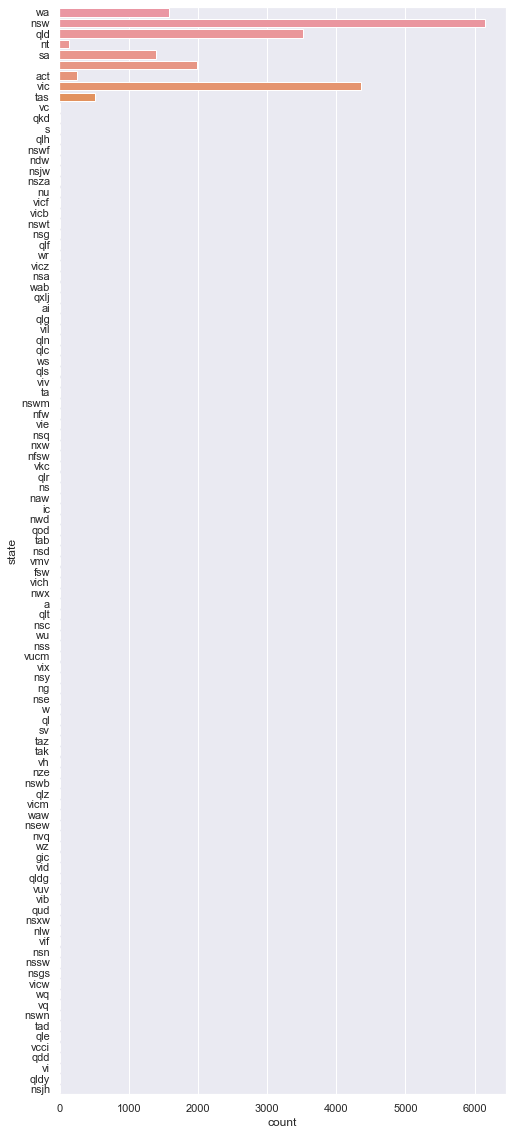

In [19]:
fig, ax = plt.subplots(figsize=(8, 20))
sns.countplot(y=df_patient.state, ax=ax)

In [20]:
df_patient.state.describe()

count     20000
unique      103
top         nsw
freq       6143
Name: state, dtype: object

In [21]:
# Value counts which are errors
(~df_patient.state.isin(['act', 'nsw', 'nt', 'qld', 'sa', 'tas', 'vic', 'wa', ""])).sum()

139

Vérification des codes postaux (variable **postcode**). Nous comptons 14 intervalles de codes postaux correspondants aux différents États et Territoires selon le site de la poste australienne (https://postcode.auspost.com.au/free_display.html?id=1) :
* 0200-0299 : act
* 0800-0999 : nt
* 1000-2599 : nsw
* 2600-2619 : act
* 2620-2899 : nsw
* 2900-2920 : act
* 2921-2999 : nsw
* 3000-3999 : vic
* 4000-4999 : qld
* 5000-5999 : sa
* 6000-6999 : wa
* 7000-7999 : tas
* 8000-8999 : vic
* 9000-9999 : qld

Cette relation entre les variables **postcode** et **state** me permettra de faire l'imputation des valeurs manquantes et la correction des erreurs de saisie de la variable **state**.

*Traitement de la variable **postcode** :*
* remplacer les valeurs manquantes par '0' (nous avons seulement **1%** de valeurs manquantes) ;
    * **tâche réalisée plus haut.**
* calculer la proportion de valeurs alphabétiques présentes ;
    * **tâche réalisée plus haut.**
* corriger les valeurs alphabétiques présentes par les valeurs correspondantes de la variable **suburb** ;
* changer le type de cette variable par le type numpy.int64 ;
* supprimer toutes les lignes qui ont pour valeur '0' ; la variable **postcode** a le plus faible pourcentage de valeurs manquantes et il est de **1%** ;
* vérifier que les valeurs numériques correspondent à celles données par la poste australienne.

In [22]:
# Indexes of alphabetic values in feature postcode
index_changing = list(df_patient[(df_patient.suburb.apply(search_numeric_values).isna() == False) | \
           (df_patient.postcode.apply(search_alphabetic_values).isna() == False)].index)

print(index_changing)

[3976, 4080, 5792, 6218, 6618, 9653, 9718, 11333, 14255, 15479, 15575, 18658, 18784, 19150]


In [23]:
# Change alphabetic values by numeric values of feature suburb
transition = ""
for index in index_changing:
    transition = df_patient.postcode.iloc[index]
    df_patient.postcode.iloc[index] = df_patient.suburb.iloc[index]
    df_patient.suburb.iloc[index] = transition

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
# Change checking
df_patient[(df_patient.suburb.apply(search_numeric_values).isna() == False) | \
           (df_patient.postcode.apply(search_alphabetic_values).isna() == False)]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number


La correction des valeurs a fonctionné et m'a permis de voir qu'une des valeurs de **postcode** à l'index 9718 est alphanumérique (valeur incohérente) 467l0. Je vais le corriger par la valeur 4670 (je supprime le *l*).

In [25]:
for index in index_changing:
    print(df_patient.postcode.iloc[index], " at the index ", index)

3023  at the index  3976
6168  at the index  4080
4216  at the index  5792
6017  at the index  6218
3185  at the index  6618
3020  at the index  9653
467l0  at the index  9718
3023  at the index  11333
6112  at the index  14255
3181  at the index  15479
3764  at the index  15575
4214  at the index  18658
4160  at the index  18784
3133  at the index  19150


In [26]:
# Correct alphanumeric value by deleting the character l
df_patient.postcode.iloc[9718] = '4670'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
# Change the type of feature postcode
df_patient.postcode = df_patient.postcode.astype(np.int64)

In [28]:
# Delete '0' values's rows
df_patient = df_patient[df_patient.postcode != 0]

In [29]:
# Check deleting
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19801 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     19801 non-null  int64  
 1   given_name     19801 non-null  object 
 2   surname        19801 non-null  object 
 3   street_number  19422 non-null  float64
 4   address_1      19801 non-null  object 
 5   suburb         19801 non-null  object 
 6   postcode       19801 non-null  int64  
 7   state          19801 non-null  object 
 8   date_of_birth  17819 non-null  float64
 9   age            15842 non-null  float64
 10  phone_number   19801 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 1.8+ MB


**Aucune valeur** de la variable **postcode** n'est en dehors des informations de la poste australienne. Elles sont comprises entre **0200-9999**.

In [30]:
df_patient[df_patient.postcode < 200].postcode.count()

0

In [31]:
df_patient[df_patient.postcode > 9999].postcode.count()

0

*Traitement de la variable **suburb** :*
* corriger toutes les valeurs manquantes (**1.06%**) par la valeur "" ;
    * **tâche réalisée plus haut.**
* calculer la proportion des valeurs numériques présentes ;
    * **tâche réalisée plus haut.**
* corriger les valeurs numériques présentes par les valeurs alphabétiques de la variable **postcode** ;
    * **tâche réalisée plus haut.**

In [32]:
# After correction
df_patient.suburb.value_counts()

               211
toowoomba      167
frankston      108
brighton        93
blacktown       92
              ... 
north tives      1
adelong          1
wooloweyah       1
meringandan      1
clayyon          1
Name: suburb, Length: 2901, dtype: int64

In [33]:
# NaN value counts
df_patient.suburb.isna().sum()

0

*Traitement des variables **given_name** et **surname** :*
* créer une variable **name** qui est la concaténation des deux variables ;
* vérifier qu'il n'y a aucune valeur manquante dans la nouvelle variable **name** ;
* supprimer les variables **given_name** et **surname**.

In [34]:
# Create the feature name
df_patient['name'] = df_patient.given_name + " " + df_patient.surname

In [35]:
# Checking of NaN values in feature name
df_patient.name.isna().sum()

0

Il se trouve dans notre jeu de données *4 lignes* où le prénom et le nom n'ont pas été renseignés.

In [36]:
df_patient[df_patient.name == " "]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,name
4598,340891,,,70.0,fawkner street,gorokan,3178,vic,19150429.0,24.0,07 49934506,
6663,211362,,,3.0,sternberg crescent,elsterneick,2502,nsw,19000422.0,32.0,03 96314344,
10664,644475,,,22.0,john xxiii college,craigmore,5046,tas,19781105.0,31.0,0,
18526,207001,,,20.0,kirkwood crescent,cooroy,3231,,19960825.0,30.0,03 16641630,


In [37]:
# Preview data
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,name
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,matisse clarke
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,joshua elrick
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,alice conboy
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,sienna craswell
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,joshua bastiaans


In [38]:
# Drop features given_name and surname
df_patient = df_patient.drop(columns=['given_name', 'surname'])

In [39]:
# Rearrange columns
df_patient = df_patient[['patient_id', 'name', 'street_number', 'address_1', 'suburb', 'state', 'postcode', \
                        'date_of_birth', 'age', 'phone_number']]

# Preview data
df_patient.head()

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
0,221958,matisse clarke,13.0,rene street,ellenbrook,wa,2527,19710708.0,32.0,08 86018809
1,771155,joshua elrick,23.0,andrea place,east preston,nsw,2074,19120921.0,34.0,02 97793152
2,231932,alice conboy,35.0,mountain circuit,prospect,nsw,2305,19810905.0,22.0,02 20403934
3,465838,sienna craswell,39.0,cumberlegeicrescent,henty,wa,3620,19840809.0,30.0,02 62832318
4,359178,joshua bastiaans,144.0,lowrie street,campbell town,nsw,4051,19340430.0,31.0,03 69359594


*Traitement de la variable **address_1** :*
* corriger toutes les valeurs manquantes (**3.98%**) par la valeur "" ;
    * **tâche réalisée plus haut.**

In [40]:
# After correction
df_patient.address_1.value_counts()

                           790
paul coe crescent           56
burkitt street              55
wilkins street              54
totterdell street           49
                          ... 
orkney place                 1
verbruggheh street           1
belbin place                 1
clavert place                1
berrebanglow creek road      1
Name: address_1, Length: 4317, dtype: int64

In [41]:
# NaN value counts
df_patient.address_1.isna().sum()

0

*Traitement de la variable **phone_number** :*
* corriger toutes les valeurs manquantes (**4.60%**) par la valeur '0' ;
    * **tâche réalisée plus haut.**

Afin de m'assurer de la qualité de cette variable, je consulte le site officiel des médias et communications d'Australie (https://www.acma.gov.au/choose-your-phone-number#types-of-phone-numbers). La longueur d'un numéro de téléphone est de 10 ; par exemple '0102030405'.

Dans notre jeu de données, il est de 11 car il est de la forme '01 02030405'.

*NB : Les 919 valeurs de longueur 1 sont celles corrigées par la valeur '0' plus haut.*

In [42]:
# Unique values of the length of each value
df_patient.phone_number.apply(len).value_counts()

11    18890
1       911
Name: phone_number, dtype: int64

In [43]:
# After correction
df_patient.phone_number.value_counts()

0              911
07 23239728      4
08 46276055      4
08 62513595      4
04 98378586      4
              ... 
02 92547437      1
03 91456912      1
07 09113972      1
04 91656705      1
04 49344694      1
Name: phone_number, Length: 17733, dtype: int64

In [44]:
# NaN value counts
df_patient.phone_number.isna().sum()

0

❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️❗️
**phone_number** pourrait être une variable explicative et très utile pour la fonction de détection de doublons.

In [45]:
df_patient[df_patient.phone_number == '03 10035431']

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
3364,622220,thomas webb,58.0,giles street,willtton,ai,2756,19670825.0,39.0,03 10035431
7161,671302,thomas webb,58.0,giles street,willetton,sa,2756,19670825.0,39.0,03 10035431
18998,397486,thomas webb,59.0,giles steeet,willetton,sa,2756,19670825.0,39.0,03 10035431
19684,499158,thomas webb,58.0,giles street,willtdeton,sa,2756,19679825.0,39.0,03 10035431


In [46]:
df_patient[df_patient.phone_number == '07 26649590']

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
4395,695600,richard hermans,2.0,goodparla street,valentine,tas,3371,19462115.0,22.0,07 26649590
8877,894878,richard hermans,13.0,goodparla street,valentine,tas,3371,NaN,22.0,07 26649590
11293,464534,richard hermans,12.0,goodparla street,valentine,tas,3371,19461125.0,22.0,07 26649590
11840,757846,ritchad hermans,12.0,goodparla street,valentine,,3371,19461125.0,22.0,07 26649590


*Traitement de la variable **state** :*
* corriger toutes les valeurs manquantes (**9.95%**) par la valeur "" ;
    * **tâche réalisée plus haut.**
* utiliser la variable **postcode** pour corriger toutes les erreurs de la variable **state** :
    * j'utilise la règle d'affectation du code postal donnée par la poste australienne :
        * 0200-0299 : act
        * 0800-0999 : nt
        * 1000-2599 : nsw
        * 2600-2619 : act
        * 2620-2899 : nsw
        * 2900-2920 : act
        * 2921-2999 : nsw
        * 3000-3999 : vic
        * 4000-4999 : qld
        * 5000-5999 : sa
        * 6000-6999 : wa
        * 7000-7999 : tas
        * 8000-8999 : vic
        * 9000-9999 : qld

In [47]:
# Correction of feature state
    # 0200-0299
df_patient.loc[(df_patient.postcode >= 200) & (df_patient.postcode < 300), 'state'] = 'act'
    # 0800-0999
df_patient.loc[(df_patient.postcode >= 800) & (df_patient.postcode < 1000), 'state'] = 'nt'
    # 1000-2599
df_patient.loc[(df_patient.postcode >= 1000) & (df_patient.postcode < 2600), 'state'] = 'nsw'
    # 2600-2619
df_patient.loc[(df_patient.postcode >= 2600) & (df_patient.postcode < 2620), 'state'] = 'act'
    # 2620-2899
df_patient.loc[(df_patient.postcode >= 2620) & (df_patient.postcode < 2900), 'state'] = 'nsw'
    # 2900-2920
df_patient.loc[(df_patient.postcode >= 2900) & (df_patient.postcode < 2921), 'state'] = 'act'
    # 2921-2999
df_patient.loc[(df_patient.postcode >= 2921) & (df_patient.postcode < 3000), 'state'] = 'nsw'
    # 3000-3999
df_patient.loc[(df_patient.postcode >= 3000) & (df_patient.postcode < 4000), 'state'] = 'vic'
    # 4000-4999
df_patient.loc[(df_patient.postcode >= 4000) & (df_patient.postcode < 5000), 'state'] = 'qld'
    # 5000-5999
df_patient.loc[(df_patient.postcode >= 5000) & (df_patient.postcode < 6000), 'state'] = 'sa'
    # 6000-6999
df_patient.loc[(df_patient.postcode >= 6000) & (df_patient.postcode < 7000), 'state'] = 'wa'
    # 7000-7999
df_patient.loc[(df_patient.postcode >= 7000) & (df_patient.postcode < 8000), 'state'] = 'tas'
    # 8000-8999
df_patient.loc[(df_patient.postcode >= 8000) & (df_patient.postcode < 9000), 'state'] = 'vic'
    # 9000-9999
df_patient.loc[(df_patient.postcode >= 9000) & (df_patient.postcode < 10000), 'state'] = 'qld'

In [48]:
# After correction
df_patient.state.value_counts()

nsw    6652
vic    4886
qld    3786
wa     1841
sa     1560
tas     527
act     372
nt      177
Name: state, dtype: int64

In [49]:
df_patient.state.isna().sum()

0

Après le traitement des variables qualitatives, je fais l'analyse suivante :
* Il y a 17067 valeurs uniques pour la variable **name** sur 19081 valeurs dans notre jeu de données ; cette variable servira clairement à la détection de doublons.
* De 102 valeurs, nous nous retrouvons à 8 valeurs uniques pour la variable **state**.
* De même que la variable **name**, la variable **phone_number** compte moins de valeurs uniques que le nombre de valeurs total dans le jeu de données ; cette variable est donc également nécessaire pour la détection de doublons.

Un aperçu des lignes dupliquées dans les variables **name** et **phone_number** révèle qu'il y a 652 lignes concernées sans les valeurs manquantes qui ont été corrigées par des '0'.

In [50]:
# After correction of all qualitative features
df_patient.describe(include=['O'])

,name,address_1,suburb,state,phone_number
count,19801,19801,19801,19801,19801
unique,17067,4317,2901,8,17733
top,emiily white,,,nsw,0
freq,13,790,211,6652,911


In [51]:
# Preview of duplicated rows in features name and phone_number
df_patient[(df_patient.name.duplicated()) & (df_patient.phone_number.duplicated()) & (df_patient.phone_number != '0')]

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
488,749150,benjamin weidenhoffer,436.0,kadina crescent,joyner,tas,7310,19541224.0,39.0,03 02607538
605,291232,alicia clarke,39.0,badenoch crescent,gidgegannup,qld,4066,19700619.0,28.0,07 16836996
1085,915131,georgia hope,176.0,constitution avenue,brunswick heads,vic,3025,19381108.0,29.0,04 70023929
1152,365956,hollie hope,42.0,blacket street,risdon vale,nsw,2154,19910814.0,33.0,08 41637341
1156,625893,isabelle benger,139.0,cotter road,bethania,nsw,2096,19810528.0,21.0,04 92251225
...,...,...,...,...,...,...,...,...,...,...
19896,535564,marcus reinbach,2.0,wangara street,hazelbrook,vic,3931,19670124.0,30.0,08 38366451
19900,916708,edward baillie,8.0,majura avdnue,bayview,qld,4118,19671201.0,NaN,04 21767460
19924,916386,corie webb,91.0,collings street,berwick,qld,4506,19880101.0,22.0,07 83704242
19949,434796,xepheren beatton,4.0,the canberea tospital,albury,nsw,2089,19910237.0,32.0,07 23534602


#### Analyse des variables numériques

In [52]:
df_patient.describe()

,patient_id,street_number,postcode,date_of_birth,age
count,19801.000000,19422.000000,19801.000000,1.781900e+04,15842.000000
mean,553955.766830,98.640562,3667.782991,1.949705e+07,27.532067
std,260246.238454,2493.522598,1402.307150,2.885459e+05,7.807732
min,100005.000000,0.000000,800.000000,1.900010e+07,0.000000
25%,329991.000000,10.000000,2485.000000,1.924122e+07,24.000000
50%,556356.000000,24.000000,3194.000000,1.950040e+07,29.000000
75%,779418.000000,60.000000,4601.000000,1.975052e+07,33.000000
max,999993.000000,342951.000000,7470.000000,1.999123e+07,92.000000


La matrice de corrélation révèle que les variables numériques sont decorrélées (faible corrélation proche de 0) entre elles.

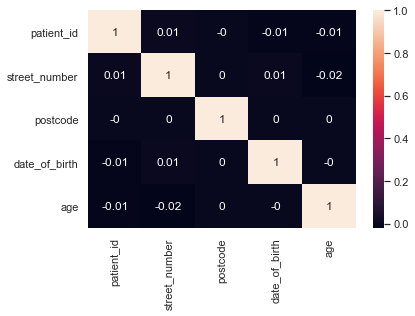

In [53]:
# Correlation between features
sns.heatmap(data=df_patient.corr().round(2), annot=True)

En affichant les codes postaux en fonction des numéros de rue, je m'aperçois clairement de 2 valeurs aberrantes apparentes qui sont supérieurs à 25000 dans la variable **street_number**. Et en utilisant Google Maps pour la localisation, ces adresses n'existent pas.

Je les remplace donc par une valeur NaN.

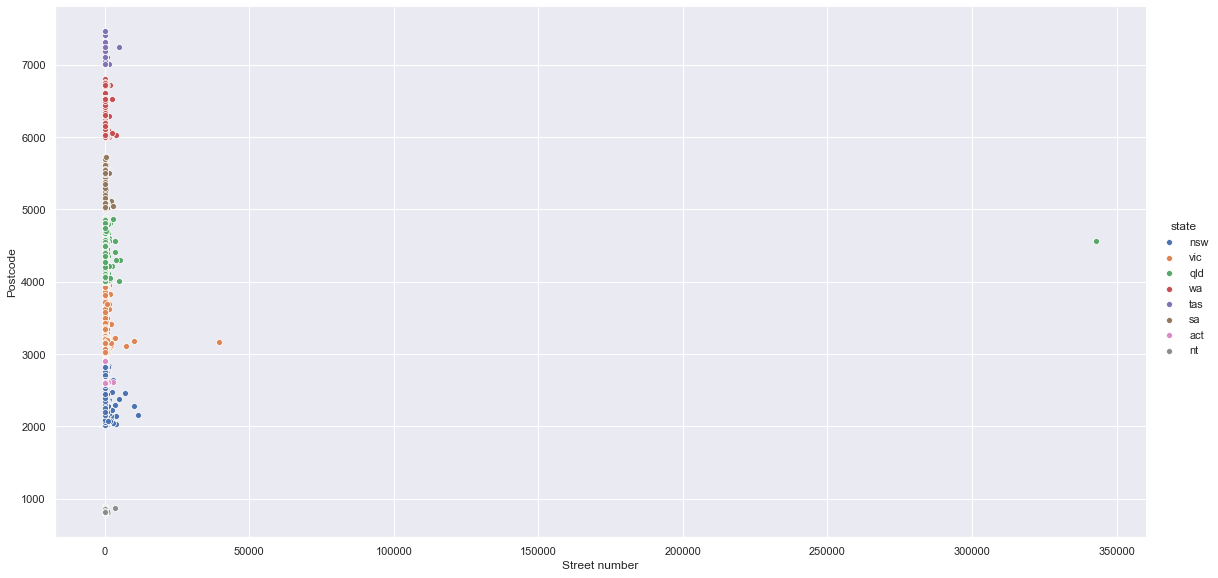

In [54]:
# Display post_code as a function of street_number and draw by state 
grid = sns.FacetGrid(data=df_patient, hue='state', height=8, aspect=2)
grid.map_dataframe(sns.scatterplot, x='street_number', y='postcode')
grid.set_xlabels(label='Street number')
grid.set_ylabels(label='Postcode')
grid.add_legend()

In [55]:
# View outliers in street_number
df_patient[df_patient.street_number > 25000]

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
7055,869217,nicholas fitzpatrick,342951.0,taylor place,normanhurst,qld,4560,19680530.0,13.0,08 37654995
12440,446997,jessica matthews,39430.0,airey crescent,plumpton,vic,3173,19331014.0,29.0,02 15333991


In [56]:
# Replace outliers in street_number by NaN value
df_patient.loc[df_patient.street_number > 25000, 'street_number'] = np.NaN

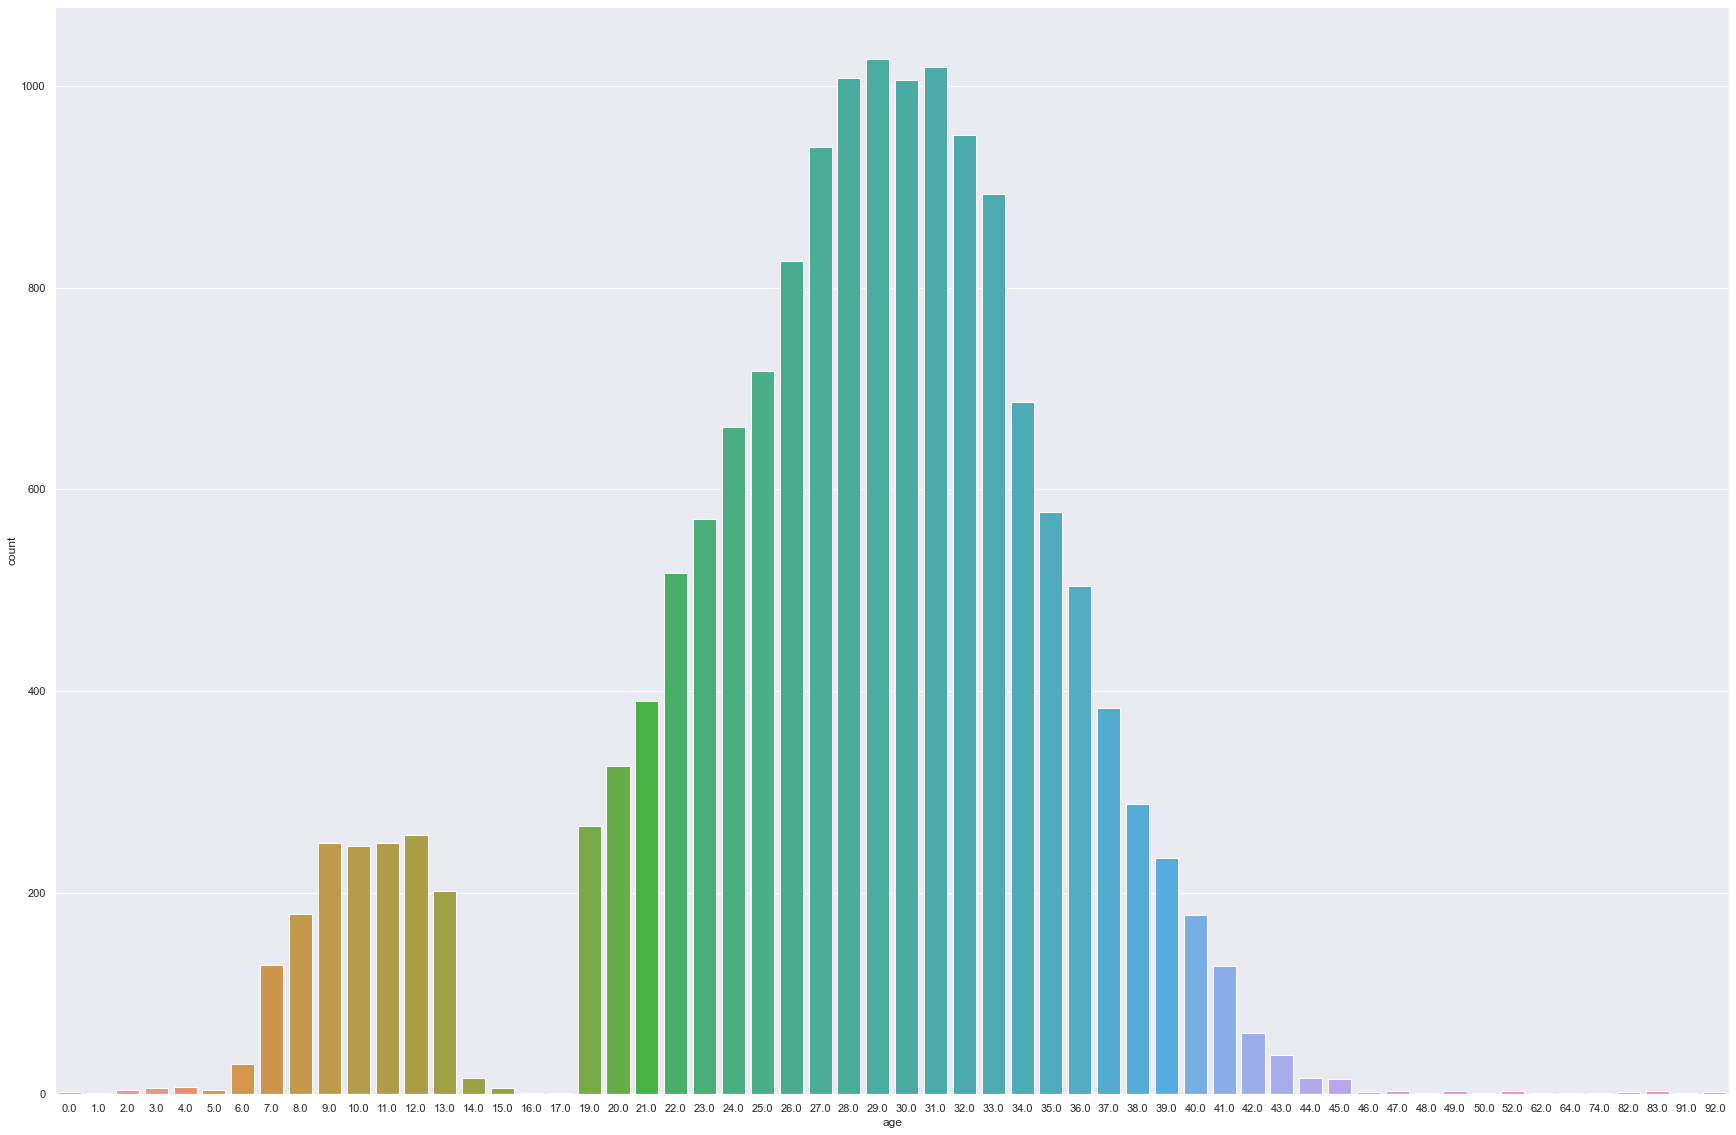

In [57]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.countplot(x=df_patient.age, ax=ax)

In [58]:
df_patient.age.isna().sum()

3959

In [59]:
print("Age mean : ", df_patient.age.mean())
print("Age median : ", df_patient.age.median())

Age mean :  27.532066658250223
Age median :  29.0


# ❗️❗️❗️❗️ A revoir la description en details des variables numeriques
Les années des dates de naissance sont de 1970 pour la plupart

In [60]:
df_patient.date_of_birth = df_patient.date_of_birth.fillna(0)

In [61]:
df_patient.date_of_birth.value_counts()

0.0           1982
19900526.0       6
19630130.0       6
19220519.0       6
19210620.0       6
              ... 
19410618.0       1
19920811.0       1
19850217.0       1
19640925.0       1
19551204.0       1
Name: date_of_birth, Length: 13542, dtype: int64

In [62]:
df_patient['date_of_birth_date'] = df_patient.date_of_birth.apply(datetime.date.fromtimestamp)

In [63]:
df_patient.date_of_birth_date.describe()

count          19801
unique            14
top       1970-01-01
freq            1982
Name: date_of_birth_date, dtype: object

In [64]:
df_patient.date_of_birth_date.value_counts()

1970-01-01    1982
1970-08-17    1681
1970-08-13    1651
1970-08-11    1612
1970-08-16    1557
1970-08-14    1548
1970-08-19    1545
1970-08-09    1523
1970-08-10    1483
1970-08-18    1465
1970-08-15    1431
1970-08-12    1406
1970-08-20     740
1970-08-08     177
Name: date_of_birth_date, dtype: int64

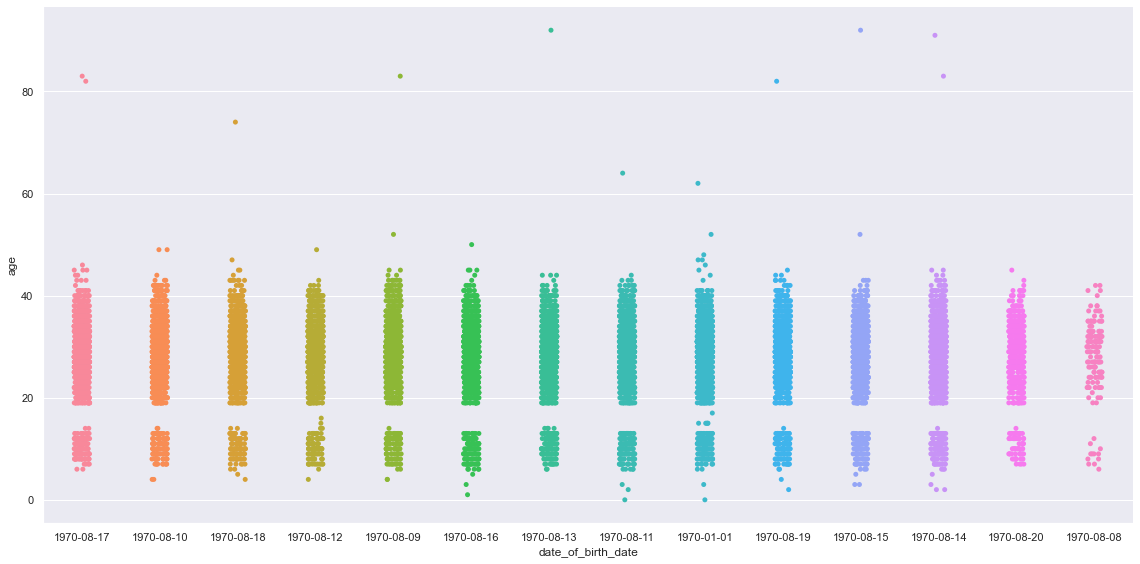

In [65]:
sns.catplot(data=df_patient, x='date_of_birth_date', y='age', height=8, aspect=2)

In [66]:
df_patient[['date_of_birth_date', 'age']].groupby('date_of_birth_date', as_index=False).\
                                                mean().sort_values('age', ascending=True)

,date_of_birth_date,age
5,1970-08-12,27.321809
4,1970-08-11,27.354380
9,1970-08-16,27.372922
8,1970-08-15,27.383290
7,1970-08-14,27.429498
13,1970-08-20,27.435200
10,1970-08-17,27.438700
12,1970-08-19,27.447737
6,1970-08-13,27.529915
3,1970-08-10,27.642978


In [67]:
print("Before correction, number of NaN values in street_number = ", df_patient.street_number.isna().sum())
(df_patient.street_number.value_counts().values == 0).sum()

Before correction, number of NaN values in street_number =  381


0

In [68]:
df_patient.street_number = df_patient.street_number.fillna(0)
print("After correction, number of NaN values in street_number = ", df_patient.street_number.isna().sum())

After correction, number of NaN values in street_number =  0


In [69]:
# Create dataframe for training
df_train = df_patient[(df_patient.street_number != 0) & (df_patient.date_of_birth != 0) & (df_patient.age.isna() == False)]\
                                            [['street_number', 'date_of_birth', 'age']]
# Preview data
df_train

,street_number,date_of_birth,age
0,13.0,19710708.0,32.0
1,23.0,19120921.0,34.0
2,35.0,19810905.0,22.0
3,39.0,19840809.0,30.0
4,144.0,19340430.0,31.0
...,...,...,...
19992,50.0,19720229.0,25.0
19993,25.0,19211111.0,34.0
19996,19.0,19590619.0,31.0
19998,1.0,19140304.0,25.0


In [70]:
train, validate, test = np.split(df_train.sample(frac=1), [int(.6*len(df_train)), int(.8*len(df_train))])

In [71]:
# Linear Regression
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
model = linear_regression.fit(train[['street_number', 'date_of_birth']], train.age)
prediction = model.predict(train[['street_number', 'date_of_birth']])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(train.age, prediction))
mae = mean_absolute_error(train.age, prediction)
r2 = r2_score(train.age, prediction)

print("ROOT MEAN SQUARED ERROR = ", rmse)
print('-'*50)
print("MEAN ABSOLUTE ERROR = ", mae)
print('-'*50)
print("R2_SCORE = ", r2)

ROOT MEAN SQUARED ERROR =  7.8124468784218495
--------------------------------------------------
MEAN ABSOLUTE ERROR =  5.872040381476242
--------------------------------------------------
R2_SCORE =  0.0002511282727434283


In [72]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
model = logistic_regression.fit(train[['street_number', 'date_of_birth']], train.age)
prediction = model.predict(train[['street_number', 'date_of_birth']])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(train.age, prediction))
mae = mean_absolute_error(train.age, prediction)
r2 = r2_score(train.age, prediction)

print("ROOT MEAN SQUARED ERROR = ", rmse)
print('-'*50)
print("MEAN ABSOLUTE ERROR = ", mae)
print('-'*50)
print("R2_SCORE = ", r2)

ROOT MEAN SQUARED ERROR =  7.965091438116661
--------------------------------------------------
MEAN ABSOLUTE ERROR =  5.794107121555529
--------------------------------------------------
R2_SCORE =  -0.03919799375518096


In [73]:
# Stochastic Gradient Descent Regressor
from sklearn.linear_model import SGDRegressor
sgd_regressor = SGDRegressor()
model = sgd_regressor.fit(train[['street_number', 'date_of_birth']], train.age)
prediction = model.predict(train[['street_number', 'date_of_birth']])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(train.age, prediction))
mae = mean_absolute_error(train.age, prediction)
r2 = r2_score(train.age, prediction)

print("ROOT MEAN SQUARED ERROR = ", rmse)
print('-'*50)
print("MEAN ABSOLUTE ERROR = ", mae)
print('-'*50)
print("R2_SCORE = ", r2)

ROOT MEAN SQUARED ERROR =  1.343326523638015e+23
--------------------------------------------------
MEAN ABSOLUTE ERROR =  1.3431800815423291e+23
--------------------------------------------------
R2_SCORE =  -2.9558333696194523e+44


In [74]:
# ARD Regression
from sklearn.linear_model import ARDRegression
ard = ARDRegression()
model = ard.fit(train[['street_number', 'date_of_birth']], train.age)
prediction = model.predict(train[['street_number', 'date_of_birth']])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(train.age, prediction))
mae = mean_absolute_error(train.age, prediction)
r2 = r2_score(train.age, prediction)

print("ROOT MEAN SQUARED ERROR = ", rmse)
print('-'*50)
print("MEAN ABSOLUTE ERROR = ", mae)
print('-'*50)
print("R2_SCORE = ", r2)

ROOT MEAN SQUARED ERROR =  7.813428026366447
--------------------------------------------------
MEAN ABSOLUTE ERROR =  5.873325458615691
--------------------------------------------------
R2_SCORE =  0.0


In [75]:
models = [linear_regression, logistic_regression, sgd_regressor, ard]
count = 1
dict_models = {}
for model in models:
    prediction = model.predict(validate[['street_number', 'date_of_birth']])
    rmse = np.sqrt(mean_squared_error(validate.age, prediction)).round(3)
    mae = mean_absolute_error(validate.age, prediction).round(3)
    r2 = r2_score(validate.age, prediction).round(3)
    
    dict_models['Model ' + str(count)] = [rmse, mae, r2]
    count += 1
    
df_models = pd.DataFrame.from_dict(dict_models, orient='index', columns=['RMSE', 'MAE', 'R2'])
df_models.sort_values(by='RMSE')

,RMSE,MAE,R2
Model 1,7.718000e+00,5.808000e+00,0.000000e+00
Model 4,7.719000e+00,5.809000e+00,-0.000000e+00
Model 2,7.855000e+00,5.724000e+00,-3.600000e-02
Model 3,1.343190e+23,1.343043e+23,-3.028474e+44


In [76]:
prediction = ard.predict(test[['street_number', 'date_of_birth']])
rmse = np.sqrt(mean_squared_error(test.age, prediction))
mae = mean_absolute_error(test.age, prediction)
r2 = r2_score(test.age, prediction)

print("ROOT MEAN SQUARED ERROR = ", rmse)
print('-'*50)
print("MEAN ABSOLUTE ERROR = ", mae)
print('-'*50)
print("R2_SCORE = ", r2)

ROOT MEAN SQUARED ERROR =  8.04127548584926
--------------------------------------------------
MEAN ABSOLUTE ERROR =  5.9269718488541745
--------------------------------------------------
R2_SCORE =  -0.0005620728370523409


In [77]:
print(prediction.mean())

27.45305976380771


In [78]:
df_patient.age.mean()

27.532066658250223

In [79]:
df_patient.age = df_patient.age.fillna(round(df_patient.age.mean(), 2))

## Question 2
*Écrire une fonction de détection et de suppression des doublons*

In [92]:
def detect_duplicates(dataframe=df_patient.copy()):
    """
    This function allows the detection and the deletion of duplicates in df_patient.
        It returns a new version of df_patient without duplicates.
    
    In our case, a duplicate is a dataframe's row that is repeated more than once taking into 
        account data entry errors.
    
    @parameter:
        dataframe: a pandas DataFrame. By default, its value is df_patient.
    @return:
        dataframe: a pandas DataFrame without duplicates.
    """
    
    # Find all unique values of phone_number that is repeated
    uniques = []
    for index, value in dataframe.phone_number.value_counts().items():
        if (value > 1) & (value < 911):
            uniques.append(index)
    
    df_duplicates = pd.DataFrame([], columns=list(dataframe.columns.values))
    for unique in uniques:
        df = dataframe[dataframe.phone_number == unique]
        df_duplicates = df_duplicates.append(df, ignore_index=True)
    
    duplicates_number = {}
    for column in df_duplicates.columns.values:
        duplicates_number[column] = len(df_duplicates[df_duplicates[column].duplicated() == True])
    df_duplicates_number = pd.DataFrame.from_dict(duplicates_number, orient='index', \
                                                  columns=['duplicates_number']).\
                                                        sort_values('duplicates_number', ascending=True)
    
    duplicates_number_reference = duplicates_number['phone_number']
    
    features_decision = list(df_duplicates_number[df_duplicates_number.duplicates_number > \
                                                  duplicates_number_reference].index)
    print(features_decision)
    df_duplicates = df_duplicates[df_duplicates.phone_number.duplicated() == True]
    for feature in features_decision:
        df_duplicates = df_duplicates[df_duplicates[feature].duplicated(keep=False) == True]
    
    patient_id_of_df_duplicates = df_duplicates.patient_id.values
    print(patient_id_of_df_duplicates.shape)
    print(dataframe.shape)
    dataframe = dataframe[~dataframe.patient_id.isin(patient_id_of_df_duplicates)]
    
    return dataframe

In [94]:
dataframe = detect_duplicates()

['postcode', 'street_number', 'age', 'date_of_birth_date', 'state']
(820,)
(19801, 11)


In [96]:
dataframe[(dataframe.phone_number.duplicated() == True) & (dataframe.phone_number != '0')]

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number,date_of_birth_date
1156,625893,isabelle benger,139.0,cotter road,bethania,nsw,2096,19810528.0,21.00,04 92251225,1970-08-18
1514,176218,reimer joe,68.0,kiewa street,windsor,tas,7091,19581213.0,26.00,04 22861452,1970-08-15
1673,221789,nicholas fitzpatrick,3429.0,taylor place,normanhuest,qld,4560,19608520.0,11.00,08 37654995,1970-08-15
2407,821864,talissa brammy,11.0,james street,maryborough,sa,5333,19060917.0,7.00,02 77001738,1970-08-09
2587,358517,anna maspn,133.0,cataractdstreet,somerton park,nsw,2035,19590915.0,27.00,04 64903061,1970-08-15
...,...,...,...,...,...,...,...,...,...,...,...
19920,629604,samir weidenohfer,5.0,garis pkace,sanctuary point,wa,6302,19730831.0,27.53,07 17344930,1970-08-17
19928,687453,jim,42.0,wynn place,wilson,wa,6201,19550480.0,12.00,02 03755662,1970-08-15
19944,131139,kone campbwell,10.0,giles strret,penshurst,qld,4700,19340223.0,10.00,02 93280129,1970-08-12
19949,434796,xepheren beatton,4.0,the canberea tospital,albury,nsw,2089,19910237.0,32.00,07 23534602,1970-08-19
